In [2]:
import os
os.chdir("../../")

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import scanpy as sc
import numpy as np

In [5]:
def subsample_selection(adata, study_key, frac=0.1, specific_cell_types=None, cell_type_key=None):
    studies = adata.obs[study_key].unique().tolist()
    if specific_cell_types and cell_type_key:
        subsampled_adata = adata[adata.obs[cell_type_key].isin(specific_cell_types)]
        other_adata = adata[~adata.obs[cell_type_key].isin(specific_cell_types)]
    else:
        subsampled_adata = None
    for study in studies:
        study_adata = other_adata[other_adata.obs[study_key] == study]
        n_samples = study_adata.shape[0]
        print(study, n_samples)
        subsample_idx = np.random.choice(n_samples, int(frac * n_samples), replace=False)
        study_adata_subsampled = study_adata[subsample_idx, :]
        subsampled_adata = study_adata_subsampled if subsampled_adata is None else subsampled_adata.concatenate(study_adata_subsampled)
    return subsampled_adata

In [6]:
def subsample_selection(adata, cell_type_key, cell_type_dict={}):
    subsampled_adata = None
    for cell_type in adata.obs[cell_type_key].unique().tolist():
        cell_type_adata = adata[adata.obs[cell_type_key] == cell_type]
        n_samples = cell_type_dict[cell_type]
        if n_samples != -1:
            cell_type_adata = sc.pp.subsample(cell_type_adata, n_obs=n_samples, copy=True)
        subsampled_adata = cell_type_adata if subsampled_adata is None else subsampled_adata.concatenate(cell_type_adata)
    return subsampled_adata

In [7]:
adata = sc.read("./data/mouse_brain/mouse_brain_normalized_hvg_all.h5ad")
adata

AnnData object with n_obs × n_vars = 978734 × 2000 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [8]:
subsampled_adata = sc.pp.subsample(adata, n_obs=70000, copy=True)
subsampled_adata

AnnData object with n_obs × n_vars = 70000 × 2000 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [9]:
sc.pp.neighbors(subsampled_adata)
sc.tl.umap(subsampled_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [11]:
sc.settings.set_figure_params(dpi=200)

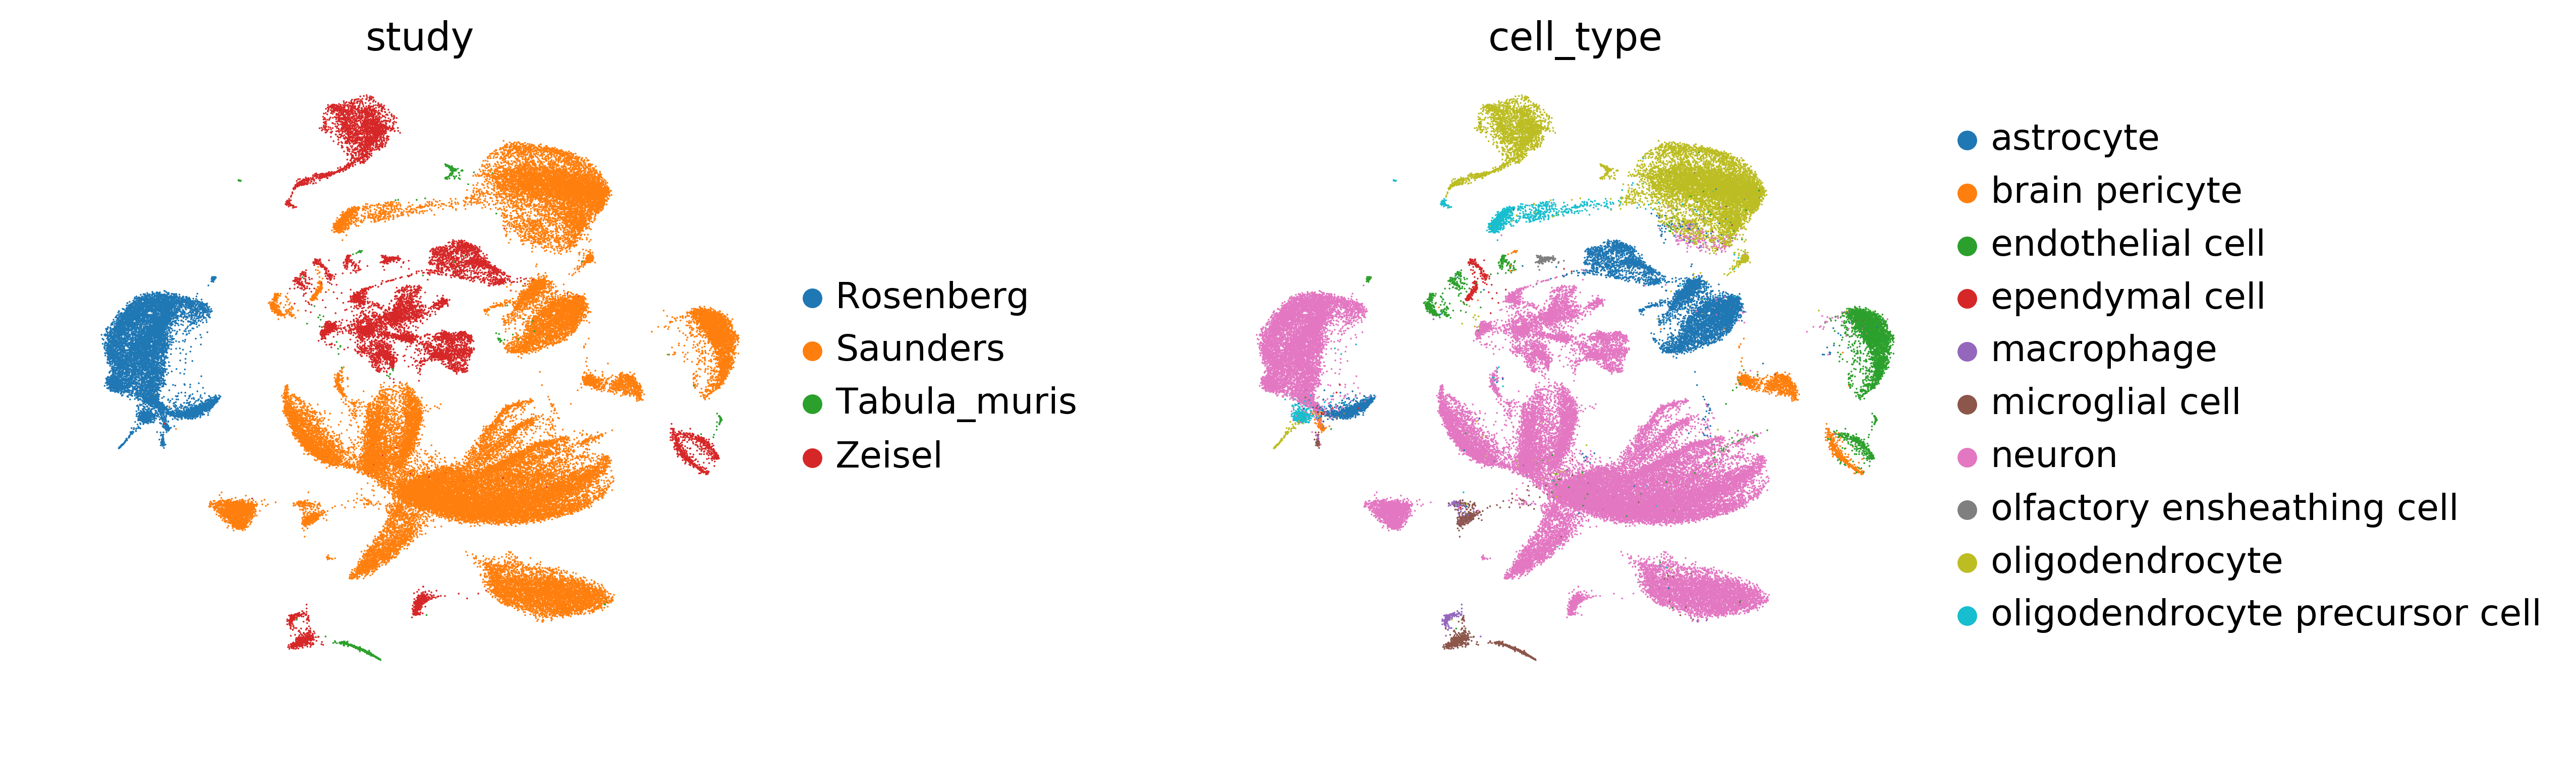

In [12]:
sc.pl.umap(subsampled_adata, color=['study', 'cell_type'], wspace=0.5, frameon=False)

In [6]:
adata.obs['study'].value_counts()

Saunders        691489
Zeisel          145954
Rosenberg       133435
Tabula_muris      7856
Name: study, dtype: int64

In [7]:
adata.obs['cell_type'].value_counts()

neuron                            628235
oligodendrocyte                   144260
astrocyte                          88530
endothelial cell                   55031
brain pericyte                     18692
oligodendrocyte precursor cell     18150
microglial cell                    15855
ependymal cell                      3851
macrophage                          3844
olfactory ensheathing cell          2286
Name: cell_type, dtype: int64

In [8]:
adata.obs.groupby(['cell_type', 'study']).size()

cell_type                       study       
astrocyte                       Rosenberg        10683
                                Saunders         56915
                                Tabula_muris       472
                                Zeisel           20460
brain pericyte                  Rosenberg         1188
                                Saunders         12135
                                Tabula_muris       156
                                Zeisel            5213
endothelial cell                Rosenberg          474
                                Saunders         46455
                                Tabula_muris       715
                                Zeisel            7387
ependymal cell                  Rosenberg          400
                                Saunders          2083
                                Zeisel            1368
macrophage                      Rosenberg           53
                                Saunders          1701
                    

In [9]:
saunders = adata[adata.obs['study'] == 'Saunders']
saunders

View of AnnData object with n_obs × n_vars = 691489 × 2000 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [10]:
saunders.obs['cell_type'].value_counts()

neuron                            443157
oligodendrocyte                   110867
astrocyte                          56915
endothelial cell                   46455
oligodendrocyte precursor cell     12625
brain pericyte                     12135
microglial cell                     5551
ependymal cell                      2083
macrophage                          1701
Name: cell_type, dtype: int64

In [12]:
cell_dict = {
    'neuron': 20000,
    'oligodendrocyte': 15000,
    'astrocyte': 10000,
    'endothelial cell': 10000,
    'oligodendrocyte precursor cell': 10000,
    'brain pericyte': 10000,
    'microglial cell': -1,
    'ependymal cell': -1,
    'macrophage': -1
}

In [16]:
saunders_subsampled = subsample_selection(saunders, 'cell_type', cell_dict)
saunders_subsampled

AnnData object with n_obs × n_vars = 84335 × 2000 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [17]:
rosenberg_adata = adata[adata.obs['study'] == 'Rosenberg']
rosenberg_adata

View of AnnData object with n_obs × n_vars = 133435 × 2000 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [18]:
rosenberg_adata.obs['cell_type'].value_counts()

neuron                            113829
astrocyte                          10683
oligodendrocyte precursor cell      4502
oligodendrocyte                     1566
brain pericyte                      1188
microglial cell                      485
endothelial cell                     474
ependymal cell                       400
olfactory ensheathing cell           255
macrophage                            53
Name: cell_type, dtype: int64

In [21]:
cell_dict = {
    'neuron': 20000,
    'oligodendrocyte': -1,
    'astrocyte': -1,
    'endothelial cell': -1,
    'oligodendrocyte precursor cell': -1,
    'brain pericyte': -1,
    'microglial cell': -1,
    'ependymal cell': -1,
    'macrophage': -1,
    'olfactory ensheathing cell': -1
}

In [22]:
rosenberg_subsampled = subsample_selection(rosenberg_adata, 'cell_type', cell_dict)
rosenberg_subsampled

AnnData object with n_obs × n_vars = 39606 × 2000 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [24]:
tabula_muris = adata[adata.obs['study'] == 'Tabula_muris']
tabula_muris

View of AnnData object with n_obs × n_vars = 7856 × 2000 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [26]:
tabula_muris.obs['cell_type'].value_counts()

microglial cell                   4394
oligodendrocyte                   1574
endothelial cell                   715
astrocyte                          472
neuron                             281
oligodendrocyte precursor cell     203
brain pericyte                     156
macrophage                          61
Name: cell_type, dtype: int64

In [25]:
zeisel = adata[adata.obs['study'] == 'Zeisel']
zeisel

View of AnnData object with n_obs × n_vars = 145954 × 2000 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [27]:
zeisel.obs['cell_type'].value_counts()

neuron                            70968
oligodendrocyte                   30253
astrocyte                         20460
endothelial cell                   7387
microglial cell                    5425
brain pericyte                     5213
olfactory ensheathing cell         2031
macrophage                         2029
ependymal cell                     1368
oligodendrocyte precursor cell      820
Name: cell_type, dtype: int64

In [28]:
cell_dict = {
    'neuron': 20000,
    'oligodendrocyte': 15000,
    'astrocyte': 15000,
    'endothelial cell': -1,
    'oligodendrocyte precursor cell': -1,
    'brain pericyte': -1,
    'microglial cell': -1,
    'ependymal cell': -1,
    'macrophage': -1,
    'olfactory ensheathing cell': -1
}

In [29]:
zeisel_subsampled = subsample_selection(zeisel, 'cell_type', cell_dict)
zeisel_subsampled

AnnData object with n_obs × n_vars = 74273 × 2000 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [31]:
subsampled_adata = saunders_subsampled.concatenate(rosenberg_subsampled, tabula_muris, zeisel_subsampled)
subsampled_adata

AnnData object with n_obs × n_vars = 206070 × 2000 
    obs: 'Age', 'Subclass', 'Taxonomy_group', 'Tissue', 'age', 'batch', 'cell_ontology_class', 'cell_ontology_id', 'cell_type', 'class', 'cluster', 'cluster_id', 'louvain', 'reason', 'refined_class', 'region', 'region_subcluster', 'sample_type', 'study', 'subcluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'

In [41]:
sc.pp.scale(subsampled_adata, zero_center=False, max_value=8, copy=True).write_h5ad("./data/mouse_brain/mouse_brain_normalized_hvg_subsampled_scaled.h5ad")

In [35]:
subsampled_adata.write_h5ad("./data/mouse_brain/mouse_brain_normalized_hvg_subsampled_2.h5ad")

... storing 'Age' as categorical
... storing 'Subclass' as categorical
... storing 'Taxonomy_group' as categorical
... storing 'Tissue' as categorical
... storing 'age' as categorical
... storing 'cell_ontology_class' as categorical
... storing 'cell_ontology_id' as categorical
... storing 'cell_type' as categorical
... storing 'class' as categorical
... storing 'cluster' as categorical
... storing 'cluster_id' as categorical
... storing 'louvain' as categorical
... storing 'reason' as categorical
... storing 'refined_class' as categorical
... storing 'region' as categorical
... storing 'region_subcluster' as categorical
... storing 'sample_type' as categorical
... storing 'study' as categorical
... storing 'subcluster' as categorical
